### 데이터 불균형

데이터 불균형이란 데이터 세트 내의 클래스의 분포가 불균형한 것을 의미한다. 데이터 불균형은 특정 클래스에 과적합 되는 현상을 유발 할 수 있기 때문에 반드시 해결해야 하는 문제다.

예를 들어, 신용 거래 데이터를 봤을 때 사기 거래에 해당되는 데이터가 현저히 적은 케이스 같은 경우이다. 

#### 1. Weighted Random Sampling

스토케스틱 그래디언트 베이스를 쓰기 때문에 일정한 수 배치가 들어온다. 이때, Weighted Random Sampling 방법은 데이터는 불균형 하더라도 배치를 균형 데이터로 뽑는 것이다. 예를 들어, 배치가 9개 이고 클래스가 3개라고 하면 항상 9개의 배치는 각각의 클래스에서 3개씩 뽑아서 만드는 것이다.

예를 들어, 개, 호랑이, 고양이 이렇게 3개의 클래스가 있을때, 개의 수가 현저히 많더라도 세개의 클래스에서 각각 3개씩 뽑아서 만든다.

In [ ]:
# 각 클래스의 비율을 정하여 뽑힐 확률에 대한 가중치를 산정한다.
import torch
from torch.utils.data import DataLoader
import torchvision
import numpy as np

def make_weights_for_balanced_classes(img, nclasses):
    labels = []

    for i in range(len(img)):
      labels.append(img[i][1]) # img는 (파일경로, 클래스 인덱스) 형태의 리스트이다. ex. [('cat1.jpg', 0), ('dog1.jpg', 1), ...])

    label_array = np.array(labels)
    total = len(labels) # 전체 데이터 수 계산

    count_list = []

    for cls in range(nclasses): # nclasses: 전체 클래스 수
      # np.where(label_array == cls)[0]
      # label_array 안에서 클래스 cls가 등장한 횟수, [0]을 붙이는 이유는 np.where()는 결과를 튜플로 반환하기 때문이다. (array([2, 4, 5]), ) 와 같은 형태이기 때문에 첫 번째 요소 list를 뽑아온다.
      count = len(np.where(label_array == cls)[0])
      count_list.append(total/count) # 예를 들어, 클래스 0이 900개, 클래스 1이 100개이면 -> 1000/900 = 1.11, 1000/100 = 10.0 이 되어, 가중치 값 리스트 count_list [1.11, 10.0]이 만들어 진다. -> 수가 적은 쪽에 더 높은 가중치를 부여한다.

    weights = []

    # ex.데이터가 [0, 0, 1, 0, 1]라면 -> weight = [1.11, 1.11, 10.0, 1.11, 10.0]
    for label in label_array:
      weights.append(count_list[label])

    return weights


In [ ]:
trainset = torchvision.datasets.ImageFolder(root='./class', transform=transf) # 데이터 세트 불러오기

# trainset과 trainloader 데이터 불균형을 잡기 위해 weighted random sampling 작업을 해준다.
weights = make_weights_for_balanced_classes(trainset.imgs, len(trainset.classes)) # 가중치 계산
weights = torch.DoubleTensor(weights) # 텐서 변환

# 가중치에 따라 확률적으로 데이터를 뽑아주는 샘플러이다.
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)) # 샘플링 방법 정의

trainloader = DataLoader(trainset, batch_size=16, sampler=sampler) # 데이터 로더 정의

#### 2. Weighted Loss Function

각각의 클래스 로스가 계산될 때, 가중치를 곱해주는 방법이다. 작은 값에는 로스를 계산할 때 큰 값을 곱해 줌으로써 데이터의 개수마다 로스의 크기를 다르게 설정해 준다.

In [ ]:
import torch.nn as nn
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

num_ins = [40,45,30,62,70,153,395,46,75,194]
weights = [1-(x/sum(num_ins)) for x in num_ins]
print(weights)
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights) # Weighted Loss Function이 적용된 가중치를 CrossEntropyLoss에 적용함

[0.963963963963964, 0.9594594594594594, 0.972972972972973, 0.9441441441441442, 0.9369369369369369, 0.8621621621621621, 0.6441441441441442, 0.9585585585585585, 0.9324324324324325, 0.8252252252252252]


#### 3. Data Augmentation
> 증강: 더 강하게 만든다. 데이터 증강은 기존 데이터를 인위적으로 변형해서 다양한 데이터를 더 많이 만든다는 의미이다.

데이터 증강은 overfitting 에서도 쓰이지만 불균형 문제에서도 사용될 수 있다. 데이터가 적은 경우에 데이터를 추가해서 데이터를 확보할 수 있게 한다.

Weighted Random Sampling과 Data Augmentation를 동시에 사용하는 경우가 많다.

In [ ]:
import torchvision.transforms as tr
import PIL

# 데이터를 
transf = tr.Compose(
                [tr.ToPILImage(), tr.RandomCrop(60), tr.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                 tr.RandomHorizontalFlip(),
                 tr.RandomRotation(10),
                 tr.ToTensor()
                 ])

### 4. Confusion Matrix

학습 후 얻은 실제 값과 예측 값을 가지고 행렬을 그려서, 어떤 클래스가 많이 차지하는지 파악한다. 그 후, 특정 클래스에 가중치를 더 줄 수 도 있고, 혹은 특정 클래스에 아그멘테이션을 더 많이 시켜 주는 식 등으로 결과를 보고 다음 액션을 취할 수 있도록 도와준다.

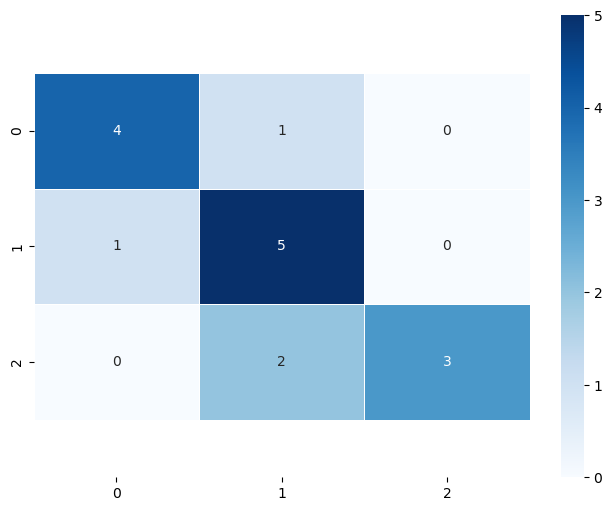

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

actual = [1,1,1,1,1,1,0,0,0,0,0,2,2,2,2,2]
prediction = [1,1,1,0,1,1,0,0,0,1,0,2,2,2,1,1]
c_mat = confusion_matrix(actual, prediction) # 실제 라벨, 예측값
plt.figure(figsize = (8,6))
sns.heatmap(c_mat, annot=True, fmt="d", cmap='Blues',linewidths=.5)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.savefig('confusion_matrix.png')
plt.show()

# x축: 모델의 예측값, y축: 실제 정답
# ↘️ 대각선 방향에 있는 값들은 모델이 정답을 맞춘 경우이다.